In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))])

cifar_10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

cifar_100_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar_100_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

In [3]:
for d in [cifar_10_trainset, cifar_10_testset, cifar_100_trainset, cifar_100_testset]:
    for i in range(4):  # Just to keep the loop structure
        temp_img, _ = d[i]
        print(temp_img.shape, temp_img.min(), temp_img.max(), temp_img.mean(), temp_img.std())
    print()

torch.Size([3, 32, 32]) tensor(0.) tensor(1.) tensor(0.4057) tensor(0.2039)
torch.Size([3, 32, 32]) tensor(0.0196) tensor(0.9961) tensor(0.5112) tensor(0.2372)
torch.Size([3, 32, 32]) tensor(0.0784) tensor(1.) tensor(0.5245) tensor(0.3238)
torch.Size([3, 32, 32]) tensor(0.0157) tensor(0.9176) tensor(0.3146) tensor(0.1431)

torch.Size([3, 32, 32]) tensor(0.0510) tensor(1.) tensor(0.4250) tensor(0.1829)
torch.Size([3, 32, 32]) tensor(0.) tensor(0.9686) tensor(0.6083) tensor(0.3081)
torch.Size([3, 32, 32]) tensor(0.0118) tensor(0.9882) tensor(0.5199) tensor(0.2570)
torch.Size([3, 32, 32]) tensor(0.1294) tensor(0.9176) tensor(0.6071) tensor(0.2212)

torch.Size([3, 32, 32]) tensor(0.0039) tensor(1.) tensor(0.5423) tensor(0.2844)
torch.Size([3, 32, 32]) tensor(0.1451) tensor(1.) tensor(0.7750) tensor(0.2939)
torch.Size([3, 32, 32]) tensor(0.0902) tensor(0.9882) tensor(0.6615) tensor(0.2632)
torch.Size([3, 32, 32]) tensor(0.) tensor(1.) tensor(0.6185) tensor(0.3185)

torch.Size([3, 32, 32]) t

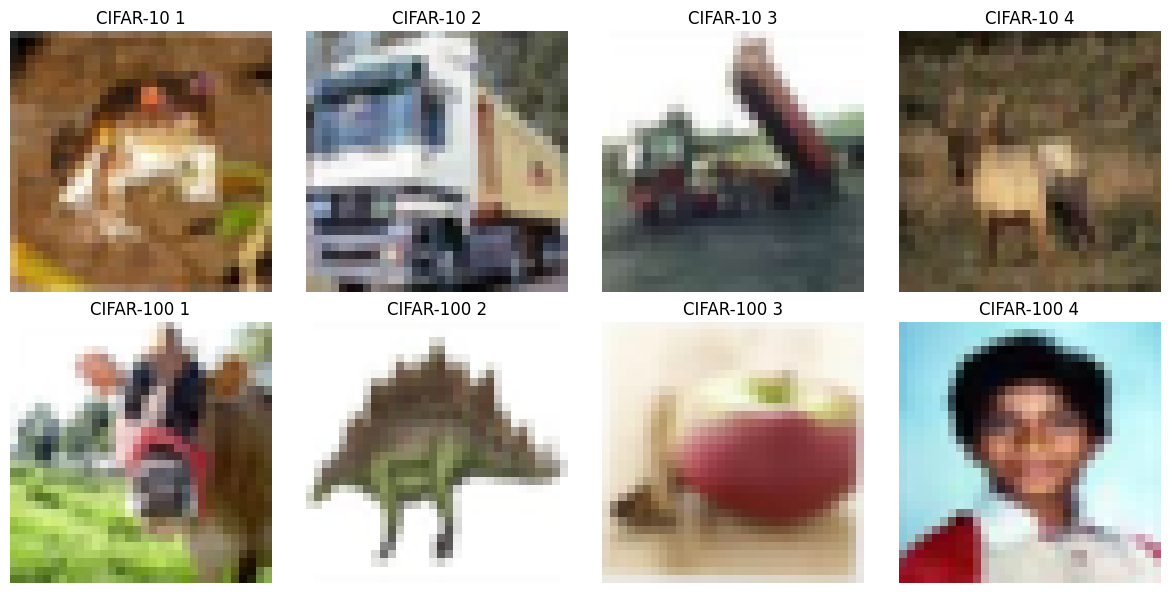

In [4]:
# helper to unnormalize and show a single tensor image on an axis
def imshow_tensor(img, ax):
    # img: torch.Tensor with shape (C, H, W) and values in [0, 1]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

# Create a 2x4 grid: first row CIFAR-10, second row CIFAR-100
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
    cifar_10_img, _ = cifar_10_trainset[i]
    cifar_100_img, _ = cifar_100_trainset[i]
    imshow_tensor(cifar_10_img, axes[0, i])
    axes[0, i].set_title(f"CIFAR-10 {i+1}")
    imshow_tensor(cifar_100_img, axes[1, i])
    axes[1, i].set_title(f"CIFAR-100 {i+1}")

plt.tight_layout()
plt.show()

In [5]:
# Small building blocks to reduce repetition and make the model clearer
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_ch)
    def forward(self, x):
        return F.gelu(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
        )
    def forward(self, x):
        return F.gelu(self.block(x) + x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # downsample 3->16
        self.initial = ConvBlock(3, 16, stride=2)
        self.res1 = nn.Sequential(
            ResidualBlock(16), 
            ResidualBlock(16), 
            ResidualBlock(16), 
        )
        # downsample 16->32
        self.down2 = ConvBlock(16, 32, stride=2)
        self.res2 = nn.Sequential(
            ResidualBlock(32), 
            ResidualBlock(32), 
            ResidualBlock(32), 
        )
        # downsample 32->64
        self.down3 = ConvBlock(32, 64, stride=2)
        self.fc_mu = nn.Linear(64 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(64 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.initial(x)
        x = self.res1(x)
        x = self.down2(x)
        x = self.res2(x)
        x = self.down3(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 64 * 4 * 4)
        self.up1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.res1 = nn.Sequential(
            ResidualBlock(32), 
            ResidualBlock(32), 
            ResidualBlock(32), 
        )
        self.up2 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1)
        self.res2 = nn.Sequential(
            ResidualBlock(16), 
            ResidualBlock(16), 
            ResidualBlock(16), 
        )
        self.up3 = nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn16 = nn.BatchNorm2d(16)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 64, 4, 4)
        x = F.gelu(self.bn32(self.up1(x)))
        x = self.res1(x)
        x = F.gelu(self.bn16(self.up2(x)))
        x = self.res2(x)
        x = torch.sigmoid(self.up3(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence, recon_loss, kl_divergence

In [7]:
device = torch.device('mps')
learning_rate = 1e-3
weight_decay = 1e-5
lr_scheduler_step_size = 35
lr_scheduler_gamma = 0.1
warmup_milestone = 2
num_epochs = 100
batch_size = 128
latent_dim = 256
plot_every = 5

In [8]:
dataloader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.ConcatDataset([
        cifar_10_trainset,
        cifar_10_testset,
        cifar_100_trainset,
        cifar_100_testset, 
    ]), 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=6, 
    persistent_workers=True,
    prefetch_factor=2,
)

vae = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, 
    schedulers=[
        torch.optim.lr_scheduler.ConstantLR(optimizer, factor=0.1, total_iters=warmup_milestone), 
        torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)
    ], 
    milestones=[warmup_milestone], 
)

# Training loop

Epoch 1/100:   0%|          | 0/938 [00:14<?, ?it/s]

Epoch 1/100 | Loss: 1966.3408 | Recon: 1940.3129 | KL: 26.0280


Epoch 2/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/100 | Loss: 1862.5109 | Recon: 1831.3876 | KL: 31.1233


Epoch 3/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/100 | Loss: 1821.6661 | Recon: 1786.3425 | KL: 35.3236


Epoch 4/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/100 | Loss: 1801.9250 | Recon: 1763.0433 | KL: 38.8816


Epoch 5/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/100 | Loss: 1797.8030 | Recon: 1757.5695 | KL: 40.2335


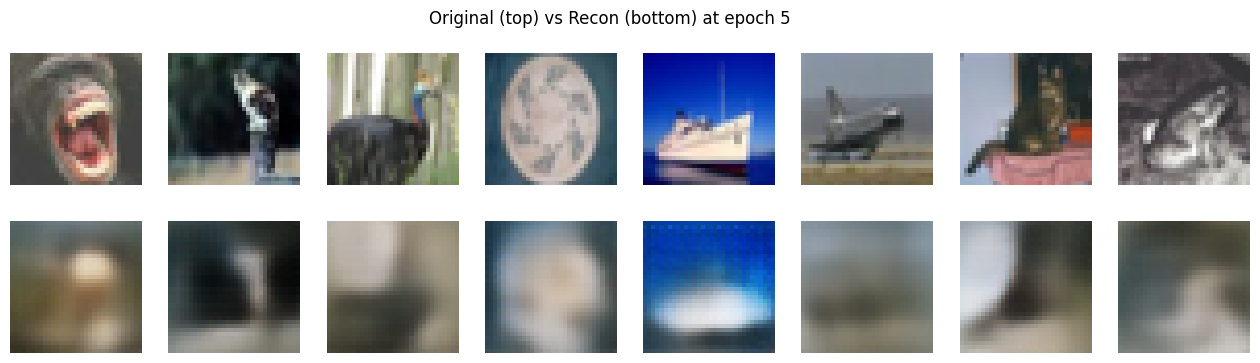

Epoch 6/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/100 | Loss: 1794.8118 | Recon: 1753.4388 | KL: 41.3730


Epoch 7/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/100 | Loss: 1792.7644 | Recon: 1750.5939 | KL: 42.1704


Epoch 8/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/100 | Loss: 1790.9066 | Recon: 1747.8966 | KL: 43.0100


Epoch 9/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/100 | Loss: 1789.1914 | Recon: 1745.6412 | KL: 43.5502


Epoch 10/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/100 | Loss: 1788.1206 | Recon: 1744.1177 | KL: 44.0029


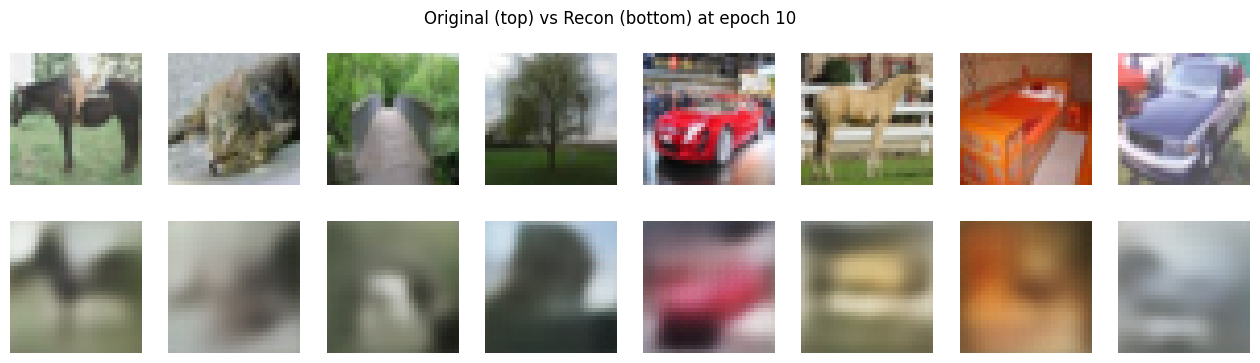

Epoch 11/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/100 | Loss: 1787.4668 | Recon: 1743.1464 | KL: 44.3204


Epoch 12/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/100 | Loss: 1786.6946 | Recon: 1742.0551 | KL: 44.6395


Epoch 13/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/100 | Loss: 1786.1025 | Recon: 1741.2330 | KL: 44.8695


Epoch 14/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/100 | Loss: 1785.7611 | Recon: 1740.6713 | KL: 45.0897


Epoch 15/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/100 | Loss: 1785.2716 | Recon: 1740.0460 | KL: 45.2256


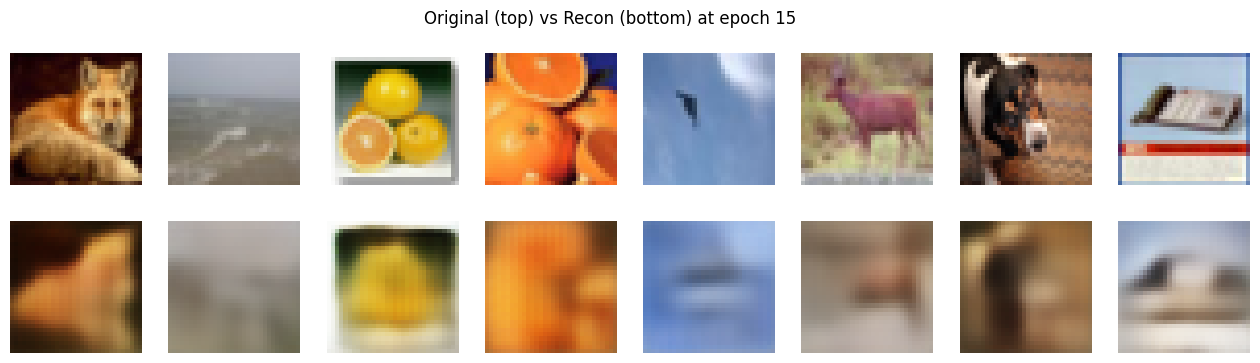

Epoch 16/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 16/100 | Loss: 1784.9211 | Recon: 1739.6083 | KL: 45.3128


Epoch 17/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 17/100 | Loss: 1784.6144 | Recon: 1739.1796 | KL: 45.4348


Epoch 18/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 18/100 | Loss: 1784.3547 | Recon: 1738.8525 | KL: 45.5023


Epoch 19/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 19/100 | Loss: 1784.0408 | Recon: 1738.5011 | KL: 45.5397


Epoch 20/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 20/100 | Loss: 1783.8174 | Recon: 1738.2090 | KL: 45.6084


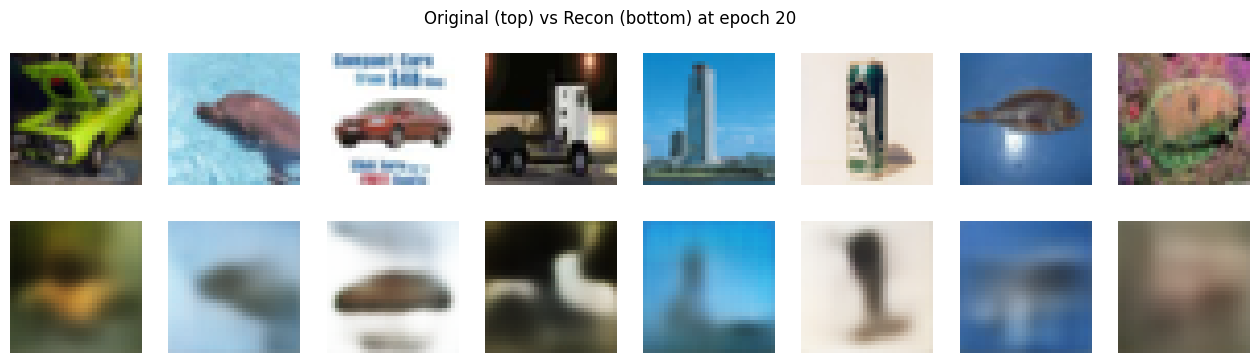

Epoch 21/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 21/100 | Loss: 1783.7352 | Recon: 1738.0416 | KL: 45.6936


Epoch 22/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 22/100 | Loss: 1783.4946 | Recon: 1737.7591 | KL: 45.7355


Epoch 23/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 23/100 | Loss: 1783.3697 | Recon: 1737.5670 | KL: 45.8027


Epoch 24/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 24/100 | Loss: 1783.0603 | Recon: 1737.2202 | KL: 45.8400


Epoch 25/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 25/100 | Loss: 1782.9590 | Recon: 1737.0396 | KL: 45.9194


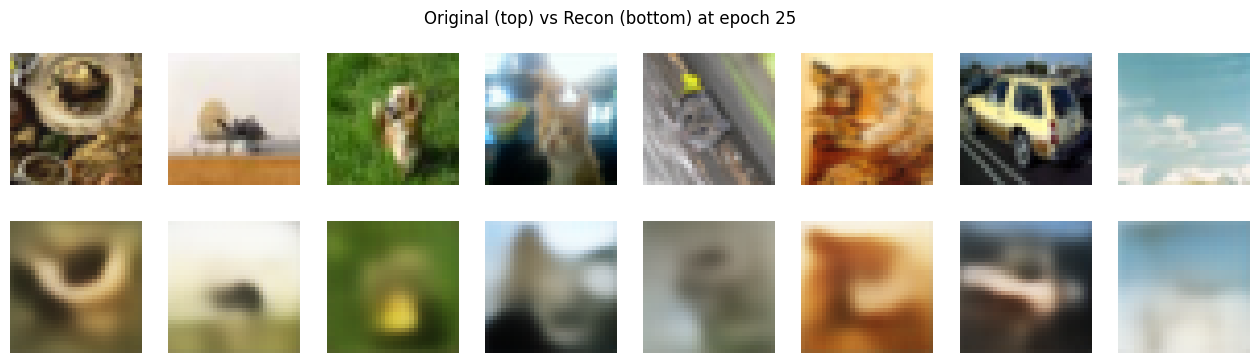

Epoch 26/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 26/100 | Loss: 1782.8916 | Recon: 1736.9389 | KL: 45.9528


Epoch 27/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 27/100 | Loss: 1782.5950 | Recon: 1736.5836 | KL: 46.0113


Epoch 28/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 28/100 | Loss: 1782.6046 | Recon: 1736.5463 | KL: 46.0583


Epoch 29/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 29/100 | Loss: 1782.4315 | Recon: 1736.3400 | KL: 46.0914


Epoch 30/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 30/100 | Loss: 1782.2806 | Recon: 1736.1262 | KL: 46.1544


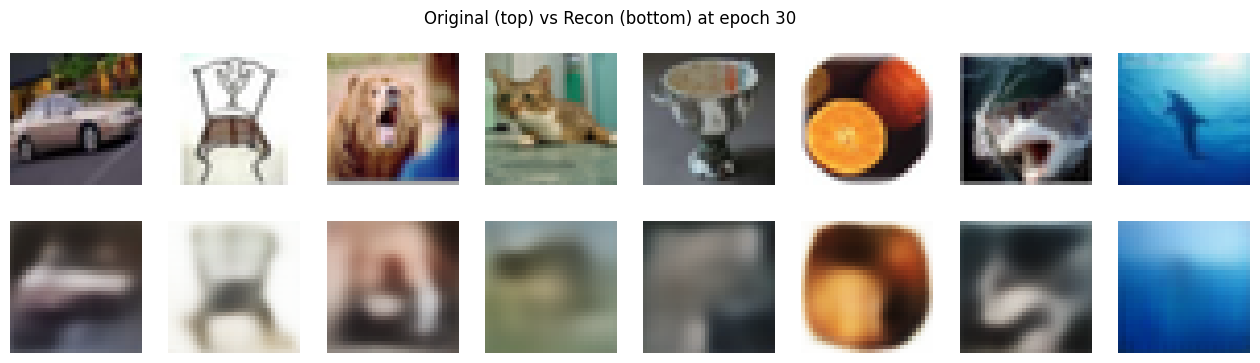

Epoch 31/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 31/100 | Loss: 1782.1284 | Recon: 1735.9385 | KL: 46.1900


Epoch 32/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 32/100 | Loss: 1782.0812 | Recon: 1735.8688 | KL: 46.2123


Epoch 33/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 33/100 | Loss: 1781.9049 | Recon: 1735.6778 | KL: 46.2271


Epoch 34/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 34/100 | Loss: 1781.8487 | Recon: 1735.5924 | KL: 46.2563


Epoch 35/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 35/100 | Loss: 1781.7873 | Recon: 1735.5164 | KL: 46.2709


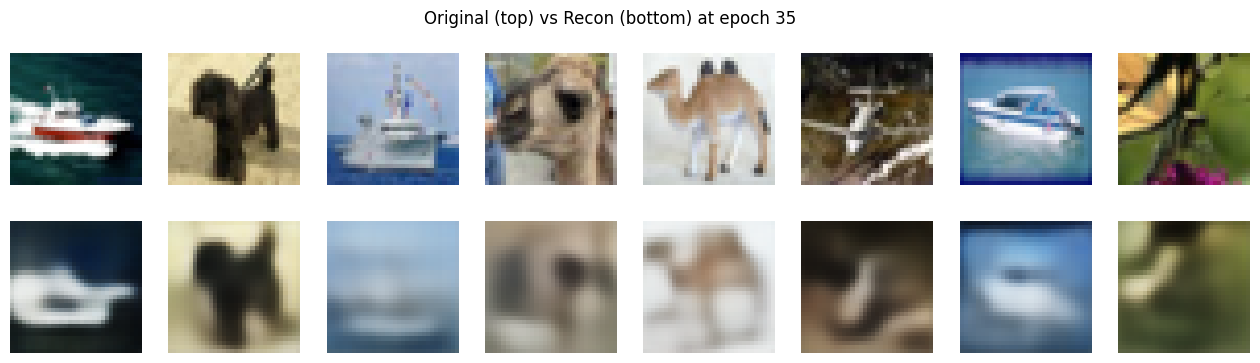

Epoch 36/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 36/100 | Loss: 1781.6210 | Recon: 1735.3191 | KL: 46.3018


Epoch 37/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 37/100 | Loss: 1781.5667 | Recon: 1735.2316 | KL: 46.3352


Epoch 38/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 38/100 | Loss: 1780.2325 | Recon: 1733.8119 | KL: 46.4205


Epoch 39/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 39/100 | Loss: 1779.9745 | Recon: 1733.4642 | KL: 46.5103


Epoch 40/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 40/100 | Loss: 1779.9197 | Recon: 1733.4150 | KL: 46.5047


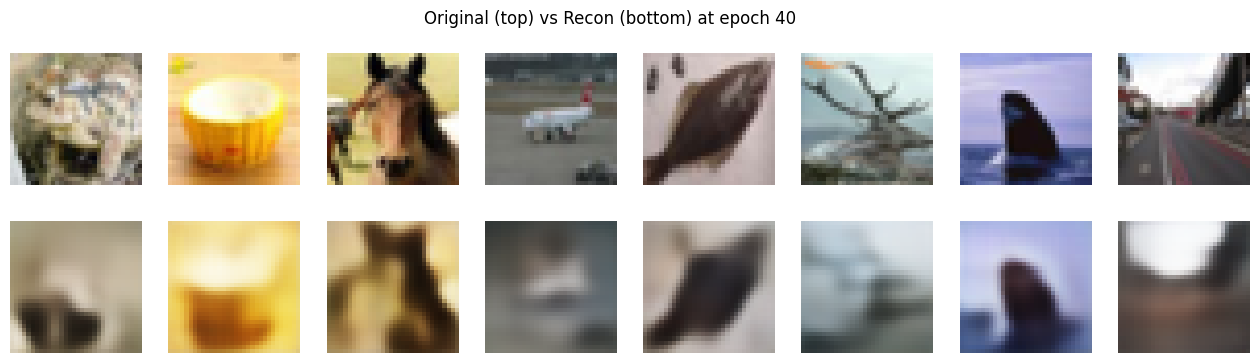

Epoch 41/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 41/100 | Loss: 1779.8853 | Recon: 1733.3526 | KL: 46.5327


Epoch 42/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 42/100 | Loss: 1779.8312 | Recon: 1733.2764 | KL: 46.5548


Epoch 43/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 43/100 | Loss: 1779.7964 | Recon: 1733.2789 | KL: 46.5175


Epoch 44/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 44/100 | Loss: 1779.8003 | Recon: 1733.2769 | KL: 46.5235


Epoch 45/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 45/100 | Loss: 1779.7753 | Recon: 1733.2207 | KL: 46.5547


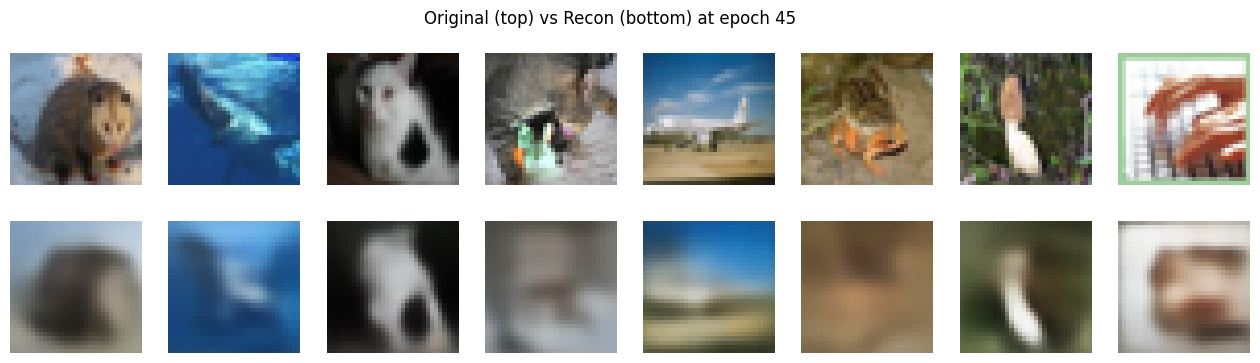

Epoch 46/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 46/100 | Loss: 1779.7843 | Recon: 1733.2177 | KL: 46.5665


Epoch 47/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 47/100 | Loss: 1779.7282 | Recon: 1733.2074 | KL: 46.5208


Epoch 48/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 48/100 | Loss: 1779.7662 | Recon: 1733.1634 | KL: 46.6028


Epoch 49/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 49/100 | Loss: 1779.7216 | Recon: 1733.1111 | KL: 46.6105


Epoch 50/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 50/100 | Loss: 1779.7344 | Recon: 1733.1678 | KL: 46.5666


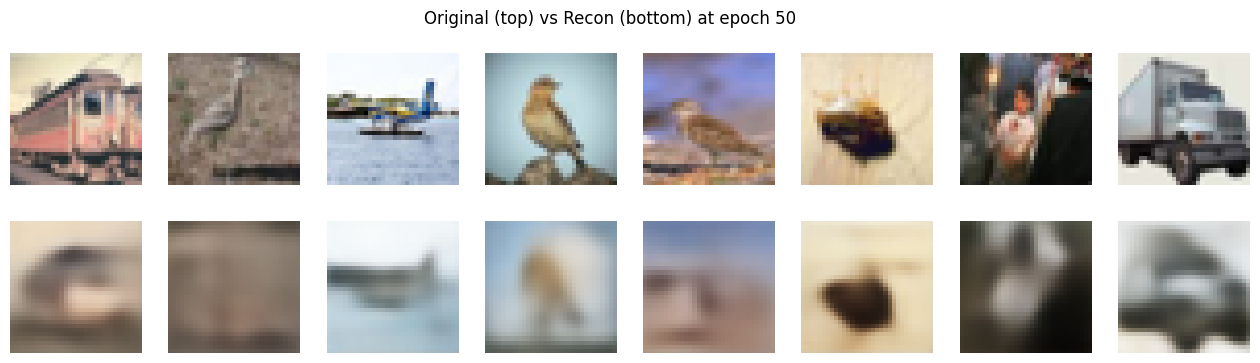

Epoch 51/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 51/100 | Loss: 1779.6671 | Recon: 1733.0937 | KL: 46.5734


Epoch 52/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 52/100 | Loss: 1779.6733 | Recon: 1733.0828 | KL: 46.5905


Epoch 53/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 53/100 | Loss: 1779.6448 | Recon: 1733.0567 | KL: 46.5882


Epoch 54/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 54/100 | Loss: 1779.6584 | Recon: 1733.0610 | KL: 46.5974


Epoch 55/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 55/100 | Loss: 1779.6372 | Recon: 1733.0412 | KL: 46.5960


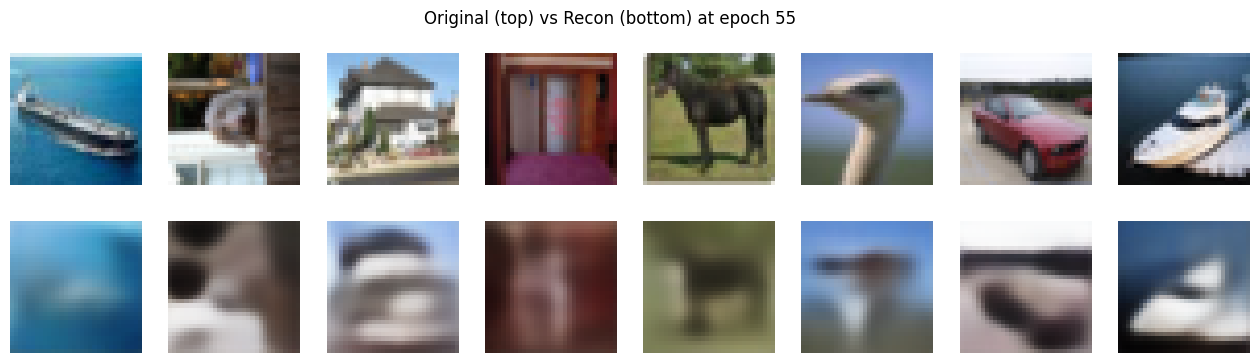

Epoch 56/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 56/100 | Loss: 1779.6106 | Recon: 1732.9937 | KL: 46.6169


Epoch 57/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 57/100 | Loss: 1779.5989 | Recon: 1732.9831 | KL: 46.6158


Epoch 58/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 58/100 | Loss: 1779.5595 | Recon: 1732.9951 | KL: 46.5644


Epoch 59/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 59/100 | Loss: 1779.5631 | Recon: 1732.9407 | KL: 46.6224


Epoch 60/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 60/100 | Loss: 1779.5697 | Recon: 1732.9473 | KL: 46.6224


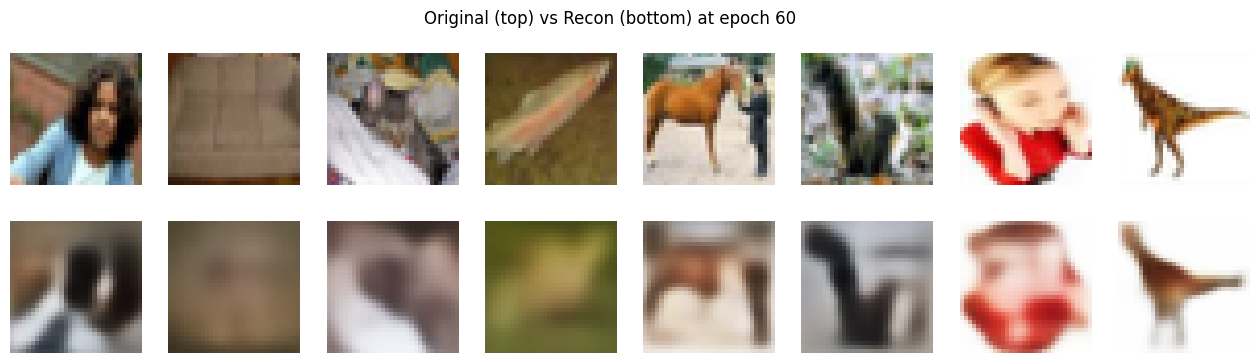

Epoch 61/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 61/100 | Loss: 1779.5739 | Recon: 1732.9711 | KL: 46.6027


Epoch 62/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 62/100 | Loss: 1779.5150 | Recon: 1732.9093 | KL: 46.6057


Epoch 63/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 63/100 | Loss: 1779.5225 | Recon: 1732.8921 | KL: 46.6304


Epoch 64/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 64/100 | Loss: 1779.5245 | Recon: 1732.9331 | KL: 46.5913


Epoch 65/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 65/100 | Loss: 1779.4974 | Recon: 1732.9139 | KL: 46.5836


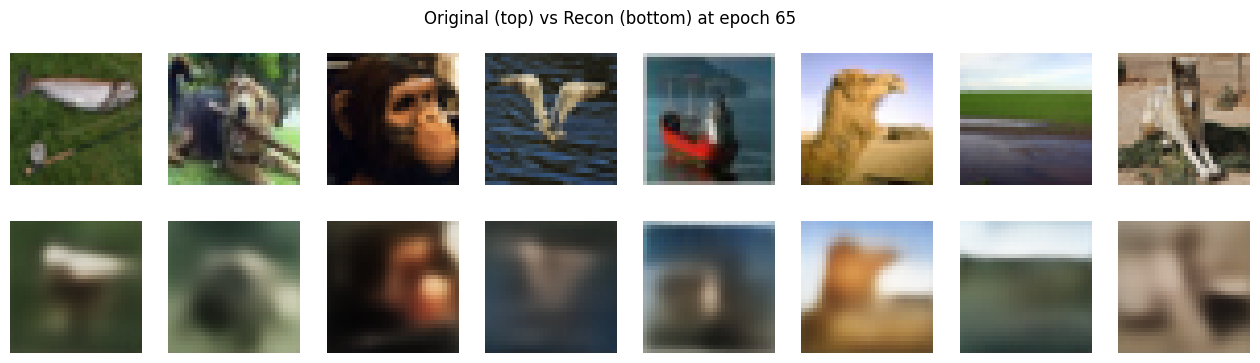

Epoch 66/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 66/100 | Loss: 1779.4904 | Recon: 1732.8813 | KL: 46.6090


Epoch 67/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 67/100 | Loss: 1779.4689 | Recon: 1732.8454 | KL: 46.6235


Epoch 68/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 68/100 | Loss: 1779.4939 | Recon: 1732.8465 | KL: 46.6474


Epoch 69/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 69/100 | Loss: 1779.5233 | Recon: 1732.8777 | KL: 46.6456


Epoch 70/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 70/100 | Loss: 1779.4485 | Recon: 1732.8393 | KL: 46.6092


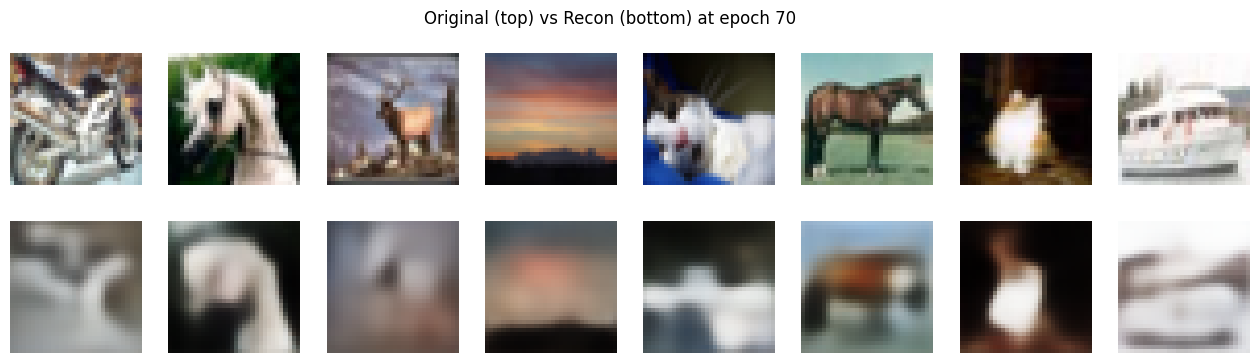

Epoch 71/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 71/100 | Loss: 1779.4396 | Recon: 1732.8291 | KL: 46.6105


Epoch 72/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 72/100 | Loss: 1779.4498 | Recon: 1732.8131 | KL: 46.6367


Epoch 73/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 73/100 | Loss: 1779.3066 | Recon: 1732.6620 | KL: 46.6447


Epoch 74/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 74/100 | Loss: 1779.2958 | Recon: 1732.6266 | KL: 46.6691


Epoch 75/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 75/100 | Loss: 1779.2618 | Recon: 1732.6077 | KL: 46.6541


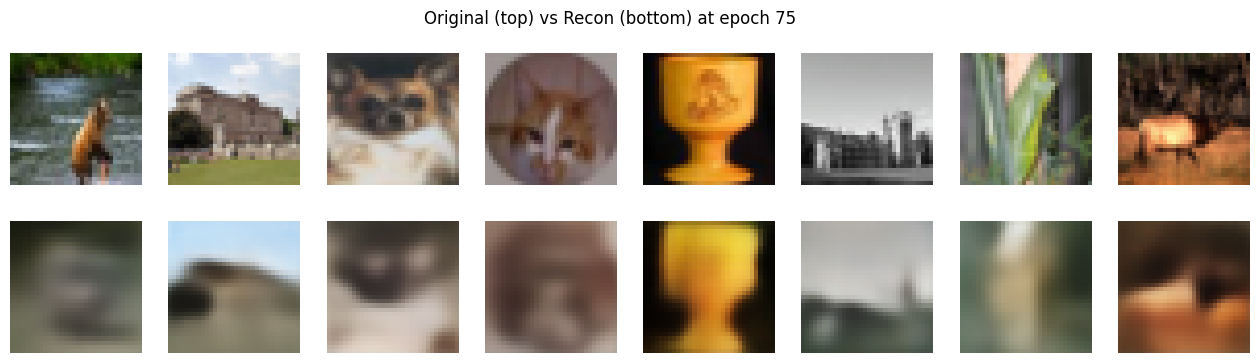

Epoch 76/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 76/100 | Loss: 1779.3126 | Recon: 1732.6436 | KL: 46.6689


Epoch 77/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 77/100 | Loss: 1779.2521 | Recon: 1732.5926 | KL: 46.6595


Epoch 78/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 78/100 | Loss: 1779.2950 | Recon: 1732.6181 | KL: 46.6770


Epoch 79/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 79/100 | Loss: 1779.2735 | Recon: 1732.6252 | KL: 46.6483


Epoch 80/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 80/100 | Loss: 1779.2916 | Recon: 1732.6527 | KL: 46.6389


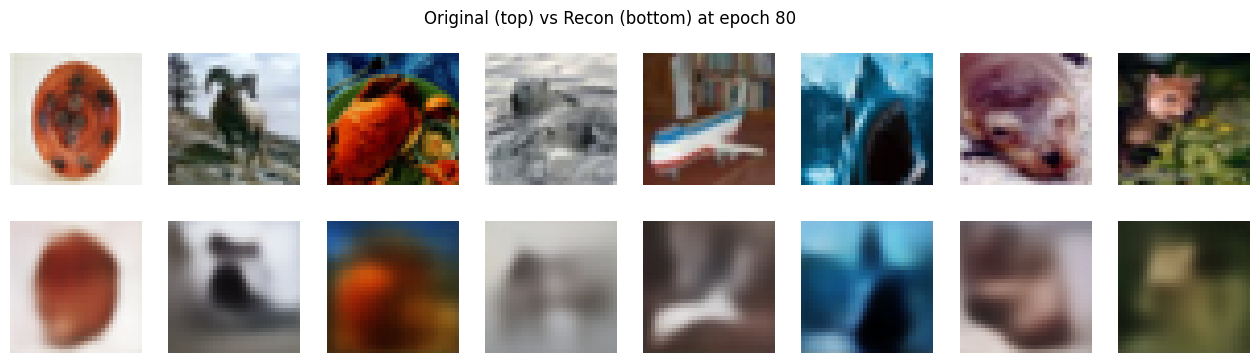

Epoch 81/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 81/100 | Loss: 1779.2081 | Recon: 1732.5724 | KL: 46.6357


Epoch 82/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 82/100 | Loss: 1779.2359 | Recon: 1732.5885 | KL: 46.6474


Epoch 83/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 83/100 | Loss: 1779.2115 | Recon: 1732.5673 | KL: 46.6442


Epoch 84/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 84/100 | Loss: 1779.2559 | Recon: 1732.6006 | KL: 46.6553


Epoch 85/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 85/100 | Loss: 1779.2319 | Recon: 1732.5823 | KL: 46.6497


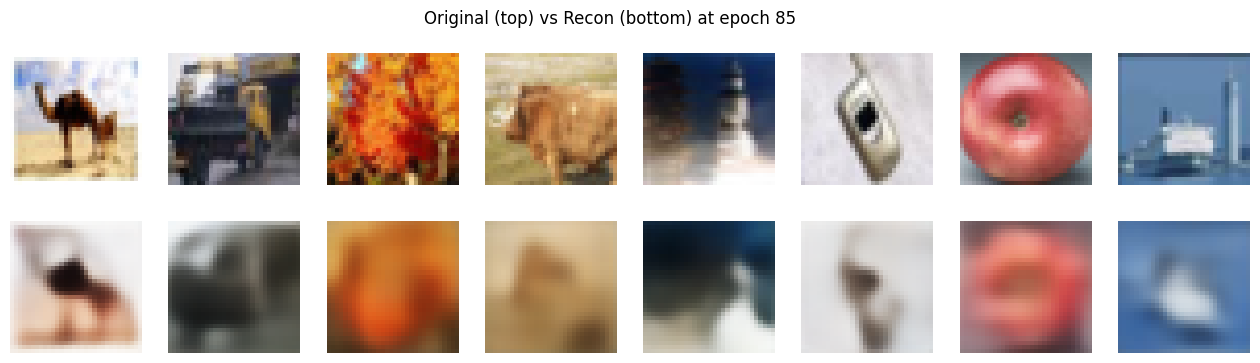

Epoch 86/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 86/100 | Loss: 1779.2512 | Recon: 1732.5796 | KL: 46.6716


Epoch 87/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 87/100 | Loss: 1779.2252 | Recon: 1732.5598 | KL: 46.6655


Epoch 88/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 88/100 | Loss: 1779.2464 | Recon: 1732.5851 | KL: 46.6613


Epoch 89/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 89/100 | Loss: 1779.2535 | Recon: 1732.5940 | KL: 46.6595


Epoch 90/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 90/100 | Loss: 1779.2069 | Recon: 1732.5773 | KL: 46.6296


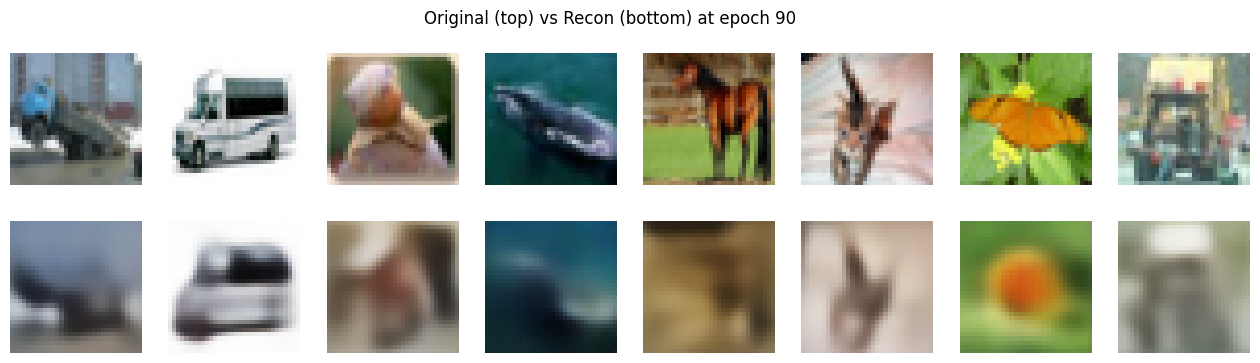

Epoch 91/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 91/100 | Loss: 1779.2449 | Recon: 1732.5969 | KL: 46.6481


Epoch 92/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 92/100 | Loss: 1779.2248 | Recon: 1732.5581 | KL: 46.6667


Epoch 93/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 93/100 | Loss: 1779.1994 | Recon: 1732.5455 | KL: 46.6539


Epoch 94/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 94/100 | Loss: 1779.2311 | Recon: 1732.5460 | KL: 46.6851


Epoch 95/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 95/100 | Loss: 1779.2010 | Recon: 1732.5457 | KL: 46.6553


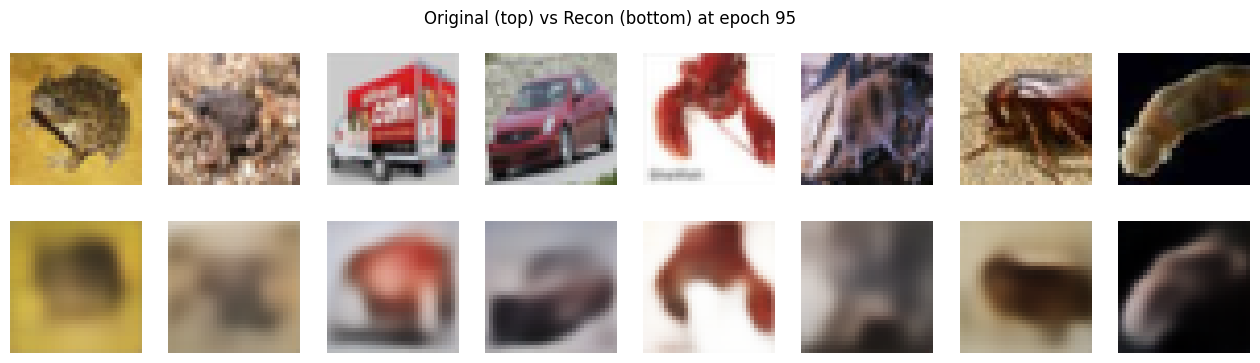

Epoch 96/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 96/100 | Loss: 1779.2249 | Recon: 1732.5642 | KL: 46.6608


Epoch 97/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 97/100 | Loss: 1779.2289 | Recon: 1732.5663 | KL: 46.6627


Epoch 98/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 98/100 | Loss: 1779.2206 | Recon: 1732.5411 | KL: 46.6794


Epoch 99/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 99/100 | Loss: 1779.2438 | Recon: 1732.5544 | KL: 46.6894


Epoch 100/100:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 100/100 | Loss: 1779.2604 | Recon: 1732.5809 | KL: 46.6795


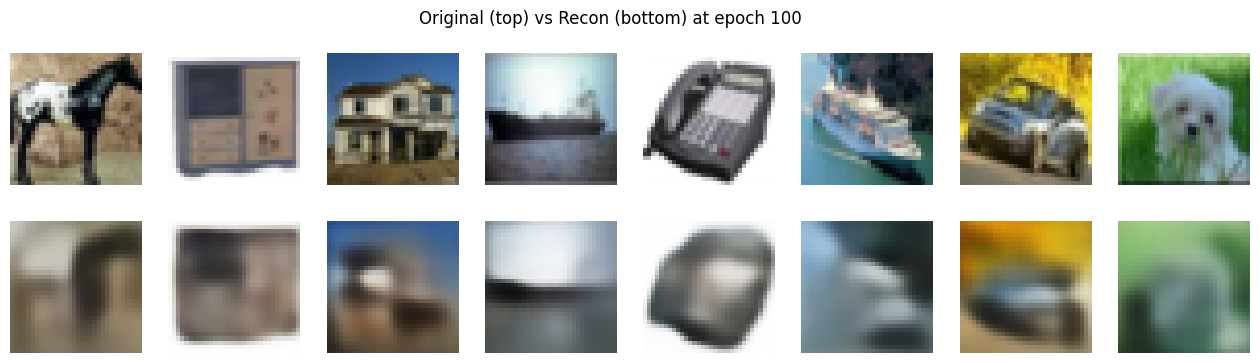

In [9]:
epoch_losses = []
epoch_recons = []
epoch_kls = []

for epoch in range(0, num_epochs):
    vae.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images = images.to(device, non_blocking=True)
        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss, recon_loss, kl = loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl.item()
    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)
    avg_kl = total_kl / len(dataloader.dataset)
    epoch_losses.append(avg_loss)
    epoch_recons.append(avg_recon)
    epoch_kls.append(avg_kl)
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

    if (epoch + 1) % plot_every == 0:
        vae.eval()
        with torch.no_grad():
            sample_images, _ = next(iter(dataloader))
            sample_images = sample_images.to(device)
            recon_images, _, _ = vae(sample_images)
        sample_images = sample_images[:8].cpu()
        recon_images = recon_images[:8].cpu()
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        for i in range(8):
            imshow_tensor(sample_images[i], axes[0, i])
            imshow_tensor(recon_images[i], axes[1, i])
        plt.suptitle(f"Original (top) vs Recon (bottom) at epoch {epoch+1}")
        plt.show()
    
    scheduler.step()

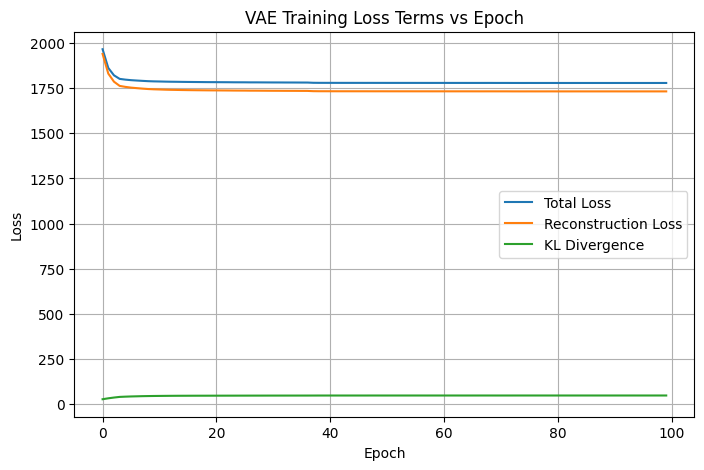

In [10]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(8, 5))
plt.plot(epoch_losses, label='Total Loss')
plt.plot(epoch_recons, label='Reconstruction Loss')
plt.plot(epoch_kls, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss Terms vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

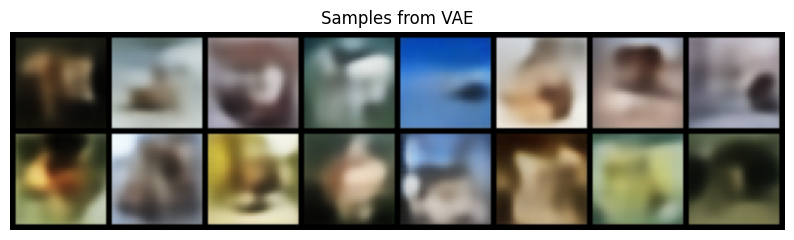

Saved generated samples to generated_samples.png


In [ ]:
# Generate images from the trained VAE's decoder
import torchvision.utils as vutils

n_samples = 16
vae.eval()
with torch.no_grad():
    # sample from standard normal in latent space
    z = torch.randn(n_samples, latent_dim).to(device)
    generated = vae.decoder(z)
    generated = generated.cpu()
    
# create a grid and show
grid = vutils.make_grid(generated, nrow=8, padding=2)
plt.figure(figsize=(10, 4))
npimg = grid.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.axis('off')
plt.title('Samples from VAE')
plt.show()